<img src="../../../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Population Coding Exercises</h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain</h2> 

In [1]:
import multiprocessing as mp
import os
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import (KFold, LeaveOneOut, RepeatedKFold,
                                     RepeatedStratifiedKFold, StratifiedKFold)
from tqdm import tqdm

import brain_observatory_utilities.datasets.behavior.data_formatting as behavior_utils
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [2]:
import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2024/"
    mp.set_start_method('fork')
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/"

<div class="alert alert-block alert-success">

<h2>Exercise 2.1: Exploring Correlations between Neurons</h2>

<p>
Finally, we turn to examine the structure of the population activity.
Does the structure of the population activity matter for this decoding, or is single-neuron tuning the whole name of the game? For example, if neurons 1 and 2 are co-active on trial 1 (both above their individual mean activity), does that carry any extra information? To explore this, we'll look at correlations between their responses.

We'll look at this correlation in much more detail below, but we should first note some assumptions. Primarily, we are studying *spike counts*, or rates within time windows defined by the stimulus. This assumes that all spikes within the windows are equivalent, no matter their relative timing. It also assumes a specific set of time windows (set by the stimulus). In some cases, these assumptions may not be desirable (e.g., in studies of time-lagged spike-spike correlation, frequently used in studies of functional connectivity.)

With that tangent aside, let's return to our observation that the neurons' activities (defined here by spike rates) are correlated.

<p>
<strong>Note:</strong>  For this exercise, there are not only comments with detailed prompts but often even code snippets for you to complete and/or run. In the later exercises we'll only provide the prompts that act as guiderails. 
</p>
    
</div>

<div class="alert alert-block alert-success">
<h3>Image decoding</h3>

In the workshop we considered a change detection task and decoded whether there was a change. Here we want to decode which image was presented.

<div class="alert alert-block alert-success">

<strong>Prompt 2.1.a:</strong> As we did in the workshop, retrieve data of session 1065437523 from the  <code>VisualBehaviorNeuropixelsProjectCache</code>.

</div>

In [3]:
cacheVB = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=data_root, use_static_cache=True)

sessionVB = cacheVB.get_ecephys_session(ecephys_session_id=1065437523)

/opt/conda/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


<div class="alert alert-block alert-success">

<strong>Prompt 2.1.b:</strong> Retrieve unit data, sort the units by depth, and filter for 'good' units using the same criteria as in the workshop.

In [4]:
### get unit and channel data, sort the units by depth and filter for "good" units
units = sessionVB.get_units() # contains information about spike waveforms, isolation quality
channels = sessionVB.get_channels() # contains information about anatomical location

unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True) # associate anatomical information with each unit

#first let's sort our units by depth and filter
unit_channels = unit_channels.sort_values('probe_vertical_position', ascending=False)

#now we'll filter them
good_unit_filter = ((unit_channels['snr']>1)&
                    (unit_channels['isi_violations']<1)&
                    (unit_channels['firing_rate']>0.1))

good_units = unit_channels.loc[good_unit_filter]

<div class="alert alert-block alert-success">
  
<strong>Prompt 2.1.c:</strong> Consider good units in <code>area_of_interest='VISp'</code> and restrict the stimulus presentations to <code>stimulus_name='Natural_Images_Lum_Matched_set_ophys_G_2019'</code> and `active=True`.

In [5]:
area_of_interest = 'VISp'
area_units = good_units[good_units['structure_acronym'] == area_of_interest]
num_units = len(area_units)

In [6]:
stimulus_presentations = sessionVB.stimulus_presentations
stimulus_presentations = stimulus_presentations[stimulus_presentations.stimulus_name == 'Natural_Images_Lum_Matched_set_ophys_G_2019']
stimulus_presentations = stimulus_presentations[stimulus_presentations.active]

<div class="alert alert-block alert-success">
  
<strong>Prompt 2.1.d:</strong> In the workshop we tried to decode the labels `'is_change'`. Here we want to decode the `'image_name'`. 
    <br>
    Modify the <code>make_response_array</code> function accordingly. 
    <br>
    Using a window size of 200ms, calculate the responses and labels using this <code>make_response_array</code> function.

In [7]:
def make_response_array(spike_times, stimulus_presentations, units, window=.05):

    '''
    Create an array of spike counts x stimulus presentations, and a corresponding list of stimulus labels.
    spike_times: spike times 
    stimulus_presentation: stimulus presentation table
    units: units table containing only the units to get the responses of
    '''

    # Sort spike times chronologically; necessary for the binary search later
    sorted_spikes = dict()
    for iu in units.index:
        # Use mergesort/timsort since most spike_times are already sorted
        sorted_spikes[iu] = np.sort(spike_times[iu], kind='mergesort')

    # Create our own copy of stimulus presentations and sort by presentation start time chronologically
    # Sorting of stimulus_presentations isn't necessary, but it speeds up the vectorized `searchsorted(...)`
    stimulus_presentations = stimulus_presentations.sort_values(by='start_time', kind='mergesort', inplace=False)

    # Calculate the duration of stimulus presentations, and drop NaN durations
    stimulus_presentations['duration'] = stimulus_presentations['end_time'] - stimulus_presentations['start_time']
    stimulus_presentations.dropna(subset='duration', inplace=True)
    
    # Warn if window size is too big
    if np.any(window > stimulus_presentations['duration']):
        print('Warning: window size longer than stimulus presentation')

    responses_by_unit = list()
    for iu in units.index:
        unit_spike_times = sorted_spikes[iu]

        # Determine the first and last spike time for each stimulus presentation
        start_is = np.searchsorted(unit_spike_times, stimulus_presentations['start_time'])
        end_is = np.searchsorted(unit_spike_times, stimulus_presentations['start_time'] + window)

        # Calculate the response rate for each stimulus presentation
        responses_by_unit.append((end_is - start_is) / window)

    # responses_by_unit has each row as a unit, and each column as a stimulus, flip so that rows are stimuli
    responses = np.transpose(responses_by_unit)

    # Extract the labels that match the responses from our sorted stimulus presentations table
    labels = np.array(stimulus_presentations['image_name'])
    
    return responses, labels

In [8]:
spike_times = sessionVB.spike_times

In [9]:
responses, labels = make_response_array(spike_times, stimulus_presentations, area_units, window=.2)

<div class="alert alert-block alert-success">

<strong>Prompt 2.1.e:</strong> Now let's decode the presented images from these responses using 5-fold cross-validation!

In [10]:
accuracies = []
confusions = []

conditions = np.unique(labels)

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(responses):
    
    clf = svm.SVC()
    clf.fit(responses[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses[test_indices])
    
    accuracy = np.mean(test_targets == test_predictions)    
    print(accuracy)
    
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions, normalize='pred'))
    
print(f"\nmean accuracy: {np.mean(accuracies)}")
print(f"chance: {1/conditions.size}")

1.0
1.0
0.9989572471324296
0.9979144942648592
0.9979144942648592

mean accuracy: 0.9989572471324296
chance: 0.1111111111111111


<div class="alert alert-block alert-success">
<h3>Computing correlation matrices</h3>

For the following analysis, we will look at Pearson correlations: the Pearson correlation for a pair of neurons is the covariance divided by the product of the neurons' standard deviations. This normalizes the measure so that its maximum is 1 and minimum is -1, which makes it easier to interpret than covariances.

So far, we have not considered how much of the covariance or correlation is stimulus-driven (e.g., reflecting neurons with similar tuning responding to the same stimulus at the same time) vs arising from other sources. 

The correlations due to the stimulus properties are called *signal correlations*, whereas correlations due to other sources (including random variability within the eyes and the brain) are called *noise correlations*. The correlations we considered above encapsulate both of these factors, and are called *total* correlations.

To separate these out, we'll now compute and compare all 3 (Pearson) correlation matrices: the total correlations, signal correlations, and noise correlations.

<div class="alert alert-block alert-success">

<strong>Prompt 2.1.f:</strong> First, calculate and plot the total correlations (using `np.corrcoef`)

Text(0, 0.5, 'Unit #')

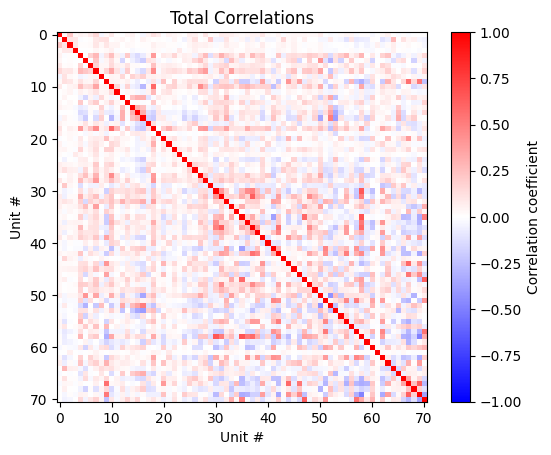

In [11]:
total_correlations = np.corrcoef(responses.T)

fig, ax = plt.subplots(1, 1)
im = ax.imshow(total_correlations, cmap='bwr', clim=(-1,1))
plt.colorbar(im, ax=ax, label='Correlation coefficient')
ax.set_title('Total Correlations')
ax.set_xlabel('Unit #')
ax.set_ylabel('Unit #')

<div class="alert alert-block alert-success">

Next, we'll compute the signal correlations. These are the correlations in the neurons' average response to each stimulus, computed across stimuli. As the name implies, they tell us how much two neurons' mean (trial averaged) activities co-vary as the stimulus changes.

To compute these, we'll first calculate the average activities for each stimulus identity and neuron.
    
<strong>Prompt 2.1.g:</strong> Plot the tuning curves for each unit

In [12]:
### Compute trial-averaged response to each stimulus (aka tuning curves) using our response array
stimuli = stimulus_presentations['image_name'].unique()
num_stim = len(stimuli)

tuning_curves = np.zeros((num_units, num_stim))

for j, stim in enumerate(stimuli):
    stim_idx = np.where(labels == stim)
    tuning_curves[:, j] = np.mean(responses[stim_idx], axis=0)

Text(0.5, 1.0, 'Tuning curves')

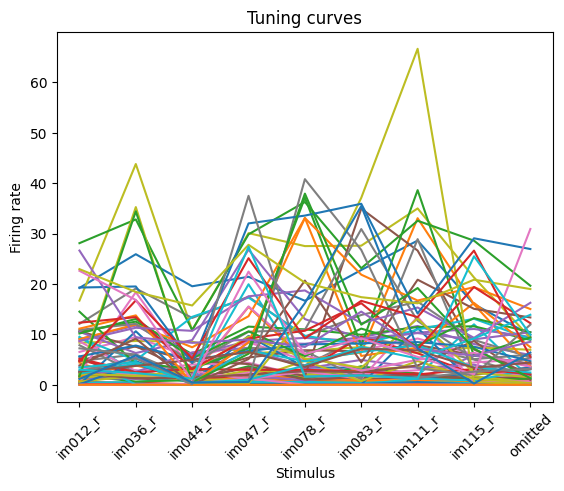

In [13]:
conditions = np.unique(labels)

fig, ax = plt.subplots(1, 1)

ax.plot(tuning_curves.T);
ax.set_xticks(range(len(conditions)), conditions, rotation=45)
ax.set_xlabel('Stimulus')
ax.set_ylabel('Firing rate')
ax.set_title('Tuning curves')

<div class="alert alert-block alert-success">

<strong>Prompt 2.1.h:</strong> The signal correlation matrix is the pearson correlation of neuron's trial-averaged responses---the similarity of their tuning curves. Calculate and plot the signal correlation matrix.

Text(0, 0.5, 'Unit #')

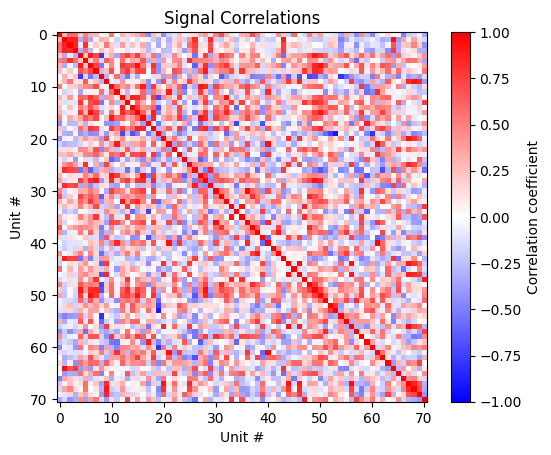

In [14]:
signal_correlations = np.corrcoef(tuning_curves)

fig, ax = plt.subplots(1, 1)
im = ax.imshow(signal_correlations, cmap='bwr', clim=(-1,1))
plt.colorbar(im, ax=ax, label='Correlation coefficient')
ax.set_title('Signal Correlations')
ax.set_xlabel('Unit #')
ax.set_ylabel('Unit #')

<div class="alert alert-block alert-success">

Finally, let's compute the noise correlations. These are the correlations in the responses to each stimulus, reflecting the (correlated) trial-to-trial variability in the neural population. These correlations can come from synaptic connections (or indirect connections) between the neurons, so that when neuron A fires more on a given trial, neuron B also fires more (excitatory connection), or neuron B fires less (inhibitory connection). The noise correlations can also come from shared input. For example, if neuron C has an excitatory projection to both neurons A and B, then on trials where neuron C has increased firing rate, then both neurons A and B will also show increased firing.

These noise correlations are defined on a per-stimulus basis and can vary somewhat between stimuli. For sake of interest, we'll plot below the correlation matrices for two different stimuli, and we'll later make use of the average correlation matrix (averaged over all 8 orientations).

<div class="alert alert-block alert-success">
    
<strong>Prompt 2.1.i:</strong> Calculate the noise correlations for each stimulus as well as their average across stimuli
    
Since noise correlations are single-trial correlations, if a neuron does not respond to a particular stimulus condition it can generate NaNs when we divide by the standard deviation of the responses. To ignore these, we use numpy's masked array module, numpy.ma.

In [15]:
noise_correlations = np.zeros((len(conditions), num_units, num_units)) # initialize the noise correlation matrix for each stimulus condition

for i, condition in enumerate(stimuli):
    condition_idx = np.where(labels == condition)
    responses_condition = responses[condition_idx]    
    noise_correlations[i] = np.ma.corrcoef(responses_condition.T)
    
mean_noise_correlations = np.mean(noise_correlations,axis=0)

print('Mean noise correlation: {}'.format(np.mean(np.triu(mean_noise_correlations, 1))))

Mean noise correlation: 0.01818016484530918


<div class="alert alert-block alert-success">
<strong>Prompt 2.1.j:</strong> Plot the noise correlations for two different stimuli, as well as their average across stimuli

Text(0, 0.5, 'Unit #')

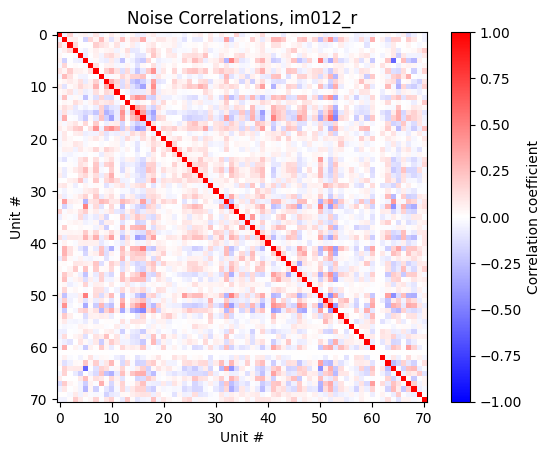

In [16]:
plot_condition_idx = 0

fig, ax = plt.subplots(1, 1)

im = ax.imshow(noise_correlations[plot_condition_idx], cmap='bwr', clim=(-1,1))
plt.colorbar(im, ax=ax, label='Correlation coefficient')
ax.set_title('Noise Correlations, {}'.format(conditions[plot_condition_idx]))
ax.set_xlabel('Unit #')
ax.set_ylabel('Unit #')

Text(0, 0.5, 'Unit #')

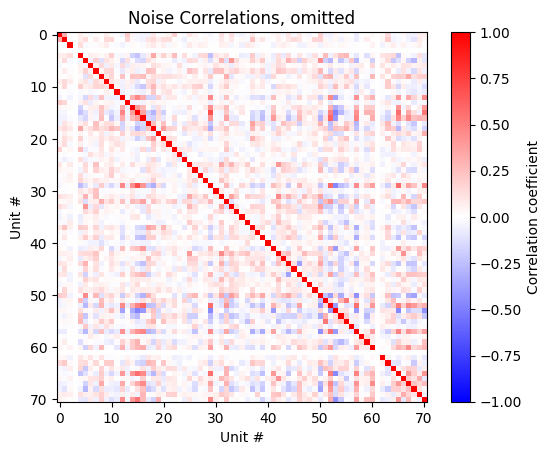

In [17]:
plot_condition_idx = -1

fig, ax = plt.subplots(1, 1)

im = ax.imshow(noise_correlations[plot_condition_idx], cmap='bwr', clim=(-1,1))
plt.colorbar(im, ax=ax, label='Correlation coefficient')
ax.set_title('Noise Correlations, {}'.format(conditions[plot_condition_idx]))
ax.set_xlabel('Unit #')
ax.set_ylabel('Unit #')

Note that noise correlations can vary between stimuli! What differences do you see between these two noise correlation matrices?

Text(0, 0.5, 'Unit #')

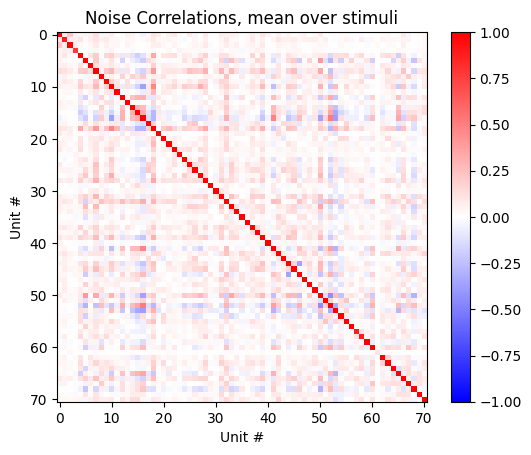

In [18]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(mean_noise_correlations, cmap='bwr', clim=(-1,1))
plt.colorbar(im)
ax.set_title('Noise Correlations, mean over stimuli')
ax.set_xlabel('Unit #')
ax.set_ylabel('Unit #')

<div class="alert alert-block alert-success">
    
A common interpretation of noise correlations is that they can arise from synapses between, or common input to, a pair of neurons. These can also affect (or, through Hebbian learning, reflect) stimulus tuning. So we might expect noise and signal correlations to be correlated.
    
The scipy.stats function pearsonr computes the pearson correlation and a a p-value from the hypothesis test where the null ypothesis is zero correlation. 
    
<strong>Prompt 2.1.k:</strong> Are the noise and signal correlations significantly correlated?   
Make sure to only compare the off-diagonal elements of the noise and signal correlation matrices, since the diagonal elements are all 1 by definition. 

Mean Noise Correlation:
0.0368797629719129
Mean Signal Correlation:
0.1203913366762584


Text(0, 0.5, 'Noise Correlation')

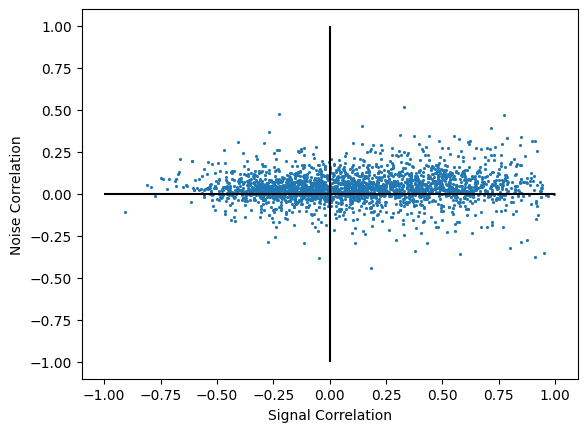

In [19]:
ncorr = np.matrix.flatten(mean_noise_correlations)
diagonal_indices = np.diag_indices(num_units, ndim=2) 
flat_diagonal_indices = np.ravel_multi_index(diagonal_indices, dims=(num_units, num_units))
ncorr = np.delete(ncorr, flat_diagonal_indices)

print('Mean Noise Correlation:')
print(np.mean(ncorr))

scorr = np.matrix.flatten(signal_correlations)
scorr = np.delete(scorr,flat_diagonal_indices)

print('Mean Signal Correlation:')
print(np.mean(scorr))

fig, ax = plt.subplots()
ax.scatter(scorr,ncorr,s=1)
ax.hlines(0,-1,1,colors='black')
ax.vlines(0,-1,1,colors='black')
ax.set_xlabel('Signal Correlation')
ax.set_ylabel('Noise Correlation')

In [20]:
from scipy.stats import pearsonr
pearsonr(ncorr,scorr)

PearsonRResult(statistic=0.06511563193507595, pvalue=4.342918239881614e-06)

Various computational models make predictions about the relation between noise and signal correlations. For example, the local competition algorithm for sparse coding, which was once a leading theory of V1 computation, predicts a negative relationship between noise and signal correlations.

<div class="alert alert-block alert-success">
<h3>Population decoding with and without noise correlations</h3>

While the noise correlations are weak, it is worth asking whether or not -- from an information processing standpoint -- we can treat each neuron as independent. In other words, are the noise correlations weak enough that they can be ignored?

To test this, we'll return to our decoding analysis, and we will try decoding from synthetic data in which we artificially remove the noise correlations. We do this by trial-shuffling the neural data. This creates a fake dataset in which non-simultaneously-recorded neural activities are assembled to make the population response vectors, and it removes the noise correlations.

<strong>Prompt 2.1.l:</strong> To do this, we go through the data, and for each stimulus, and for each neuron, we randomly (and independently) re-order the trials.

In [21]:
def trial_shuffle_responses(responses, conditions):
    
    shuffled_responses = responses.copy()

    for i, condition in enumerate(conditions):
        condition_idx = np.where(labels == condition)

        for j in range(num_units):
            responses_unit_condition = responses[condition_idx, j].reshape(-1).copy()
            np.random.shuffle(responses_unit_condition) # shuffle in place
            shuffled_responses[condition_idx, j] = responses_unit_condition
            
    return shuffled_responses

shuffled_responses = trial_shuffle_responses(responses, conditions)

<div class="alert alert-block alert-success">
<strong>Prompt 2.1.m:</strong>  First, let's double-check that our shuffling worked correctly. Compute the noise correlations in the shuffled data, and plot the histogram of the off-diagonal elements of the true noise correlations and of the shuffled-response noise correlations. 
    
We'd expect to see that the trial-shuffled noise correlations are distributed closely around 0, with non-zero values only due to the finite sampling.

In [22]:
shuffled_noise_correlations = np.zeros((len(conditions), num_units, num_units)) # initialize the noise correlation matrix for each stimulus condition

for i, condition in enumerate(conditions):
    condition_idx = np.where(labels == condition)
    responses_condition = shuffled_responses[condition_idx]
    responses_condition = np.ma.masked_invalid(responses_condition)
    
    shuffled_noise_correlations[i] = np.ma.corrcoef(responses_condition.T)

Mean noise correlation after trial shuffling: -0.00021416204813298607


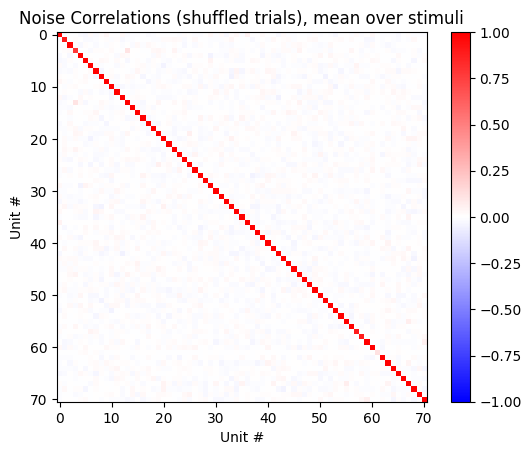

In [23]:
mean_shuffled_noise_correlations = np.mean(shuffled_noise_correlations,axis=0)

fig, ax = plt.subplots(1, 1)
im = ax.imshow(mean_shuffled_noise_correlations, cmap='bwr', clim=(-1,1))
plt.colorbar(im)
ax.set_title('Noise Correlations (shuffled trials), mean over stimuli')
ax.set_xlabel('Unit #')
ax.set_ylabel('Unit #')

print('Mean noise correlation after trial shuffling: {}'.format(np.mean(np.triu(mean_shuffled_noise_correlations, 1))))

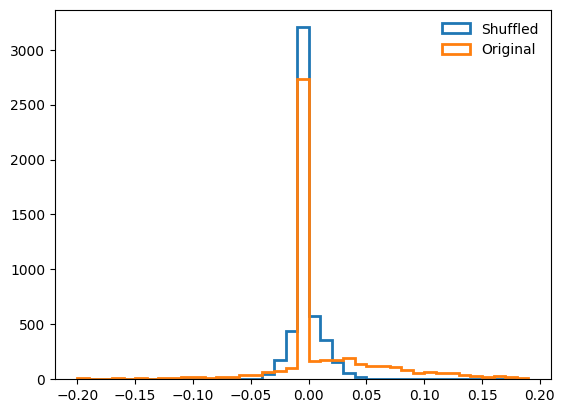

In [24]:
bins=np.arange(-.2, .2, .01)

fig, ax = plt.subplots()
ax.hist(np.triu(mean_shuffled_noise_correlations, 1).reshape(-1,), bins=bins, histtype='step', linewidth=2, label='Shuffled')
ax.hist(np.triu(mean_noise_correlations, 1).reshape(-1,), bins=bins, histtype='step', linewidth=2, label='Original')
ax.legend(loc=0, frameon=False)

<div class="alert alert-block alert-success">
<strong>Prompt 2.1.n:</strong>     
Now let's decode from the trial-shuffled responses!

In [25]:
accuracies_shuffled = []
confusions_shuffled = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(responses):

    clf = svm.SVC()

    clf.fit(shuffled_responses[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(shuffled_responses[test_indices])
    
    accuracy = np.mean(test_targets == test_predictions)    
    print(accuracy)
    
    accuracies_shuffled.append(accuracy)
    confusions_shuffled.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions, normalize='pred'))
    
print(f"\nmean accuracy, shuffled trials: {np.mean(accuracies_shuffled)}")
print(f"chance: {1/conditions.size}")

0.9958333333333333
0.996875
0.9989572471324296
0.9979144942648592
0.9979144942648592

mean accuracy, shuffled trials: 0.9974989137990962
chance: 0.1111111111111111


<div class="alert alert-block alert-success">

<h2>Exercise 2.2: Decoding for Different Brain Areas, Behavioral States, and Stimuli</h2>

<p>
In Exercise 2.1 we looked at decoding performance, restriciting the analysis to 
<ol>
<li>one brain area ('VISp'),</li>
<li>one stimulus set ('Natural_Images_Lum_Matched_set_ophys_G_2019'), and</li>
<li>only one type of trials ('active')</li>
</ol>
It's time to generalize! Let's plot the decoding performance for each brain area recorded seperated by running/not running trials. Consider further all stimulus sets with moderate amount (10-500) of stimulus conditions.

<p>
<strong>Note:</strong>  For this exercise, there are comments with detailed prompts that act as guiderails. But feel free to try completing the task objectives using your own approach first, and consulting our prompts if you get stuck.
</p>
    
</div>

<div class="alert alert-block alert-success">

<strong>Prompt 2.2.a:</strong> As we did in the workshop, retrieve data of session 1065437523 from the  <code>VisualBehaviorNeuropixelsProjectCache</code>.

In [26]:
cacheVB = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=data_root, use_static_cache=True)

sessionVB = cacheVB.get_ecephys_session(ecephys_session_id=1065437523)

/opt/conda/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


<div class="alert alert-block alert-success">

<strong>Prompt 2.2.b:</strong> Obtain the <strong>annotated</strong> stimulus presentations for the session using the <code>behavior_utils</code> package.

</div>

In [27]:
annotated_stim_table = behavior_utils.get_annotated_stimulus_presentations(sessionVB)
annotated_stim_table.columns

name 'change_time' is not defined


Index(['stimulus_block', 'image_name', 'duration', 'start_time', 'end_time',
       'start_frame', 'end_frame', 'is_change', 'is_image_novel', 'omitted',
       'flashes_since_change', 'trials_id', 'position_x', 'active',
       'position_y', 'color', 'spatial_frequency', 'contrast',
       'temporal_frequency', 'rewarded', 'orientation', 'is_sham_change',
       'stimulus_name', 'stimulus_index', 'licks', 'mean_running_speed',
       'mean_pupil_width', 'reward_rate', 'engaged', 'engagement_state',
       'epoch'],
      dtype='object')

<div class="alert alert-block alert-success">

<strong>Prompt 2.2.c:</strong> Plot histograms of <code>mean_pupil_width</code> and <code>mean_running_speed</code>.

</div>

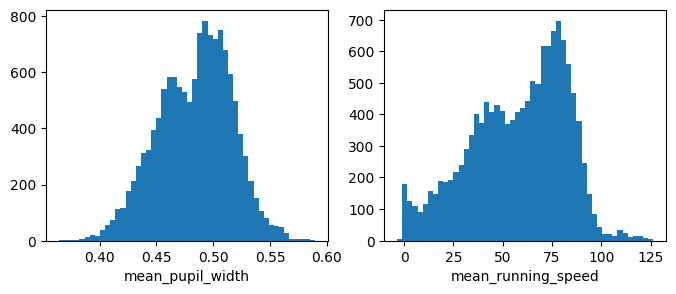

In [28]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
for i, key in enumerate(("mean_pupil_width", "mean_running_speed")):
    ax[i].hist(annotated_stim_table[key],50)
    ax[i].set_xlabel(key);

<div class="alert alert-block alert-success">

<strong>Prompt 2.2.d:</strong> As we just observed, in the VB dataset, the mice were nearly always running. To consider a dataset that includes trials where mice are 'not running', let's turn to the VC dataset. Retrieve data of session 798911424 from the <code>EcephysProjectCache</code>.

</div>
<details>
    <summary>Click for <strong>Hint:</strong></summary>
    The manifest is located in the data subfolder <code>allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/manifest.json</code>.
</details>

<h2 align="center"> The Visual Coding (VC) stimulus sets </h2> 
<img src="../../../resources/neuropixels_stimulus_sets.png">  

In [29]:
cache = EcephysProjectCache.from_warehouse(manifest=os.path.join(data_root, "allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/manifest.json"))

session = cache.get_session_data(798911424)

/opt/conda/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/opt/conda/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


<div class="alert alert-block alert-success">

<strong>Prompt 2.2.e:</strong> Retrieve unit data, sort the units by depth, and filter for 'good' units using the same criteria as in the workshop.

</div>
<details>
    <summary>Click for <strong>Hints:</strong></summary>
    Unlike for VB (Prompt 2.2.b), here the session object has no <code>get_units</code> method, but a <code>units</code> attribute that already contains channel information, thus no merging is necessary.
</details>

In [30]:
units = session.units # contains information about spike waveforms, isolation quality
units = units.sort_values('probe_vertical_position', ascending=False)
#now we'll filter them
good_unit_filter = ((units['snr']>1)&
                    (units['isi_violations']<1)&
                    (units['firing_rate']>0.1))
good_units = units.loc[good_unit_filter]

/opt/conda/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/opt/conda/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/opt/conda/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/opt/conda/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


<div class="alert alert-block alert-success">

<strong>Prompt 2.2.f:</strong> Get the <code>stimulus_presentations</code> table for the session and create a list of the <code>stimulus_names</code> with at least 10 but less than 500 stimulus conditions.

</div>

In [31]:
stim_table = session.stimulus_presentations
stim_table.stimulus_name.unique()

/opt/conda/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/opt/conda/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


array(['spontaneous', 'gabors', 'flashes', 'drifting_gratings',
       'natural_movie_three', 'natural_movie_one', 'static_gratings',
       'natural_scenes', 'drifting_gratings_contrast'], dtype=object)

In [32]:
stimulus_names = []
for name in stim_table.stimulus_name.unique():
    num_conditions = len(stim_table[stim_table.stimulus_name == name].stimulus_condition_id.unique())
    print(name, num_conditions)
    if (num_conditions >=10) * (num_conditions<500):
        stimulus_names.append(name)
stimulus_names

spontaneous 1
gabors 243
flashes 2
drifting_gratings 41
natural_movie_three 3600
natural_movie_one 900
static_gratings 121
natural_scenes 119
drifting_gratings_contrast 36


['gabors',
 'drifting_gratings',
 'static_gratings',
 'natural_scenes',
 'drifting_gratings_contrast']

<div class="alert alert-block alert-success">

<strong>Prompt 2.2.g:</strong> Calculate the average running speed for each trial and add them as new column <code>'mean_running_speed'</code> to the stimulus table.

</div>
<details>
    <summary>Click for a <strong>Hint:</strong></summary>
    For VB the <code>behavior_utils</code> package provides a convenient function to obtain an annotated stimulus table, whereas here for VC we need to do spell out the calculation steps ourselves.
</details>

In [33]:
%%time
speed = session.running_speed

def speed_for_trial(trial):
    return speed[(speed.start_time >= stim_table.iloc[trial].start_time) &
                 (speed.end_time < stim_table.iloc[trial].stop_time)].velocity.mean()

cpus = None if ((tmp:=os.environ.get("CO_CPUS")) is None) else int(tmp)
stim_table["mean_running_speed"] = mp.Pool(cpus).map(speed_for_trial, range(len(stim_table)))

CPU times: user 2.84 s, sys: 462 ms, total: 3.3 s
Wall time: 27.5 s


<div class="alert alert-block alert-success">

<strong>Prompt 2.2.h:</strong> Plot a histogram of running speeds, indicating a threshold of 5 cm/s.

</div>

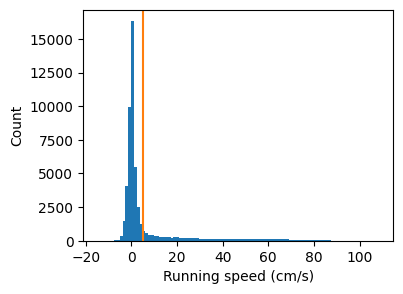

In [34]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
ax.hist(stim_table["mean_running_speed"],100)
ax.axvline(5, c='C1')
ax.set_xlabel('Running speed (cm/s)')
ax.set_ylabel('Count');

<div class="alert alert-block alert-success">

<strong>Prompt 2.2.i:</strong> Add a new column to the stimulus table named <code>'running'</code>, with values set to <code>True</code> if the running speed is greater than 5 cm/s, otherwise <code>False</code>.

</div>

In [35]:
stim_table["running"] = stim_table["mean_running_speed"] > 5

<div class="alert alert-block alert-success">

<strong>Prompt 2.2.j:</strong> Try using the <code>make_response_array</code> function using the session's spike times and stimulus table.
<p>
Why does it fail? Modify the stimulus table as needed to ensure the function succeeds. (Alternatively, you could modify the function.)
    
</div>

<details>
    <summary>Click for a <strong>Hint:</strong></summary>
    We want to decode <code>'stimulus_condition_id'</code>. Rename (or duplicate) appropriate columns to <code>'end_time'</code> and <code>'image_name'</code> respectively.
</details>

In [36]:
# make_response_array(session.spike_times, stim_table, good_units[good_units['structure_acronym'] == 'VISp'], window=.1)

In [37]:
stim_table.rename(columns={'stop_time': 'end_time', 'stimulus_condition_id': 'image_name'}, inplace=True)

<div class="alert alert-block alert-success">

<strong>Prompt 2.2.k:</strong> Plot the number of good units (y-axis) for each brain structure (x-axis).  

</div>

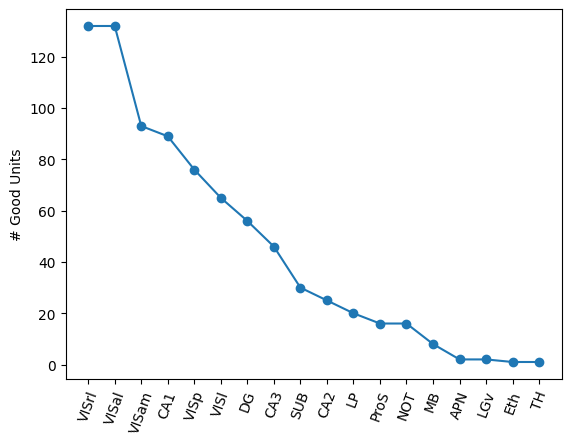

In [38]:
structures = good_units['structure_acronym'].unique()
plt.plot(good_units['structure_acronym'].value_counts(), 'o-')
plt.ylabel("# Good Units")
plt.xticks(range(len(structures)), structures, rotation=70);

<div class="alert alert-block alert-success">

<strong>Prompt 2.2.l:</strong> Create a function <code>decode(area_of_interest, selection, window, n_splits)</code> that returns the accuracies of stimulus decoding in <code>area_of_interest</code> for a given <code>selection</code> of stimulus presentations.
</div>

<details>
    <summary>Click for <strong>Hints:</strong></summary>
    Revisiting the steps performed in the workshop will help to create the function that
    <ol>
    <li>selects from the <code>good_units</code> the ones in the <code>area_of_interest</code> (see Prompt 2.2.e)</li>
    <li>selects the stimulus presentations from our annotated stimulus presentations table according to the <code>selection</code> dictionary (see Prompt 2.2.f+g)</li>
    <li>creates <code>responses</code> and <code>labels</code> using the function <code>make_response_array</code> with window size <code>window</code></li>
    <li>uses <code>sklearn.model_selection.KFold</code> to split the data into "train" and "test" sets for <code>n_splits</code> iterations, and for each iteration trains a <code>sklearn.svm.SVC</code> on the training set and calculates the accuracy on the test set</li>
    <li>returns a list/array of length <code>n_splits</code> with the accuracies for each split</li>
    </ol>
    The signature of the function with default args could be 
    <p>
    <code>def decode(area_of_interest='VISp',
            selection={"stimulus_name": 'natural_scenes', "running": True},
            window=.25,
            num_splits=5):</code>
    </p>
</details>

In [39]:
def decode(area_of_interest='VISp',
           selection={"stimulus_name": 'natural_scenes', "running": True},
           window=.25,
           n_splits=5):

    area_units = good_units[good_units['structure_acronym'] == area_of_interest]

    stimulus_presentations = stim_table.copy()
    for k, v in selection.items():
        stimulus_presentations = stimulus_presentations[stimulus_presentations[k] == v]

    responses, labels = make_response_array(session.spike_times, stimulus_presentations, area_units, window=window)

    np.random.seed(0)
    accuracies = []
    for train_indices, test_indices in KFold(n_splits=n_splits, shuffle=True).split(responses):
        clf = svm.SVC()
        clf.fit(responses[train_indices], labels[train_indices])
        test_targets = labels[test_indices]
        test_predictions = clf.predict(responses[test_indices])
        accuracy = np.mean(test_targets == test_predictions)    
        accuracies.append(accuracy)
            
    return np.array(accuracies)

<div class="alert alert-block alert-success">

<strong>Prompt 2.2.m:</strong> Equipped with this function, 
<p> for each <code>stimulus_name</code> from Prompt 2.2.f, (i.e. 'gabors', 'drifting_gratings', 'static_gratings', 'natural_scenes', 'drifting_gratings_contrast'),
<p> &emsp;&emsp; for both <code>"running"</code> and <code>"not_running"</code> trials,
<p> &emsp;&emsp;&emsp;&emsp; calculate and store the decoding accuracy for each recorded brain <code>structure</code>.
</div>

<details>
    <summary>Click to receive a <strong>Hint</strong> for faster processing:</summary>
    You could use <code>multiprocessing.Pool(processes).map()</code> to speed up processing by applying the <code>decode</code> function to all <code>structures</code> in parallel.
    <br>You might run out of memory if you use too many <code>processes</code>. On CodeOcean, don't use more than <code>os.environ.get("CO_CPUS")</code>
</details>

In [40]:
cpus = None if ((tmp:=os.environ.get("CO_CPUS")) is None) else int(tmp)
accuracies = {}
for stimulus_name in stimulus_names:
    accuracies[stimulus_name] = {}
    for name, selection in tqdm((("running", {"running": True}),
                                 ("not_running", {"running": False}),
                               )):
        selection["stimulus_name"] = stimulus_name
        my_decode = partial(decode, selection=selection)
        accuracies[stimulus_name][name] = mp.Pool(cpus).map(my_decode, structures)

 50%|█████     | 1/2 [01:05<01:05, 65.11s/it]

100%|██████████| 2/2 [01:13<00:00, 36.94s/it]


<div class="alert alert-block alert-success">

<strong>Prompt 2.2.n:</strong> For each considered <code>stimulus_name</code>, create a figure with an error bar plot of decoding accuracy (y-axis) for each brain area (x-axis) for "running" trials. Add another error bar plot for "not_running" trials using a different color in the same figure, and include a horizontal line indicating chance level performance.

</div>

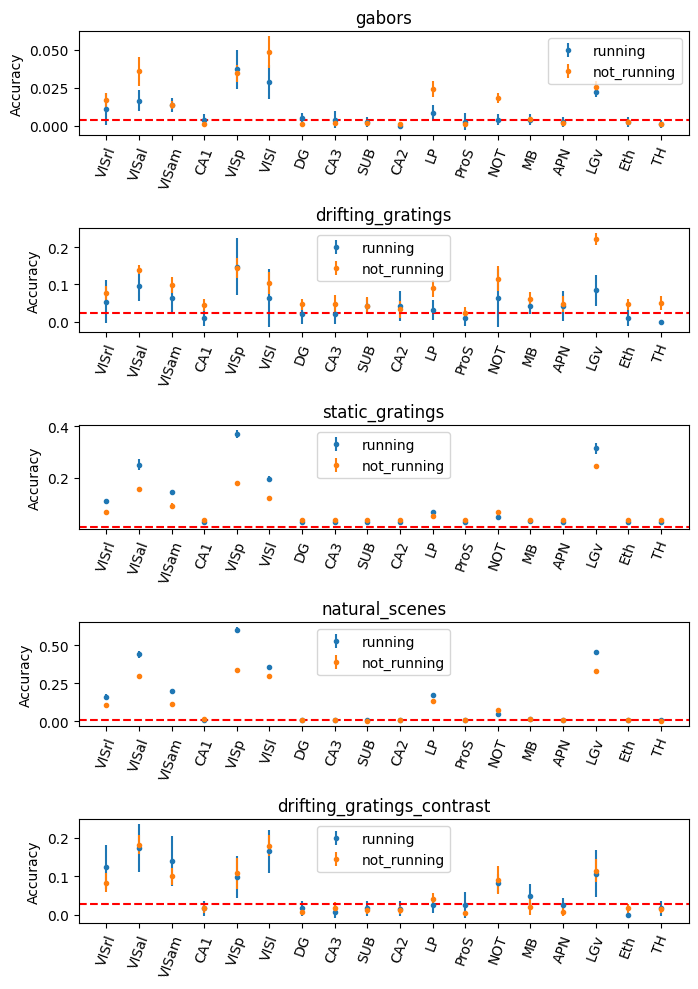

In [41]:
fig,ax = plt.subplots(len(stimulus_names),1,figsize=(7,10))
for i,name in enumerate(stimulus_names):
    for label in ("running", "not_running"):
        ax[i].errorbar(range(len(structures)), np.mean(accuracies[name][label], 1), np.std(accuracies[name][label], 1), 
                     marker='.', ls='none', label=label)
    ax[i].legend()
    ax[i].set_ylabel("Accuracy")
    ax[i].set_xticks(range(len(structures)), structures, rotation=70)
    ax[i].set_title(name)
    num_conditions = len(stim_table[stim_table.stimulus_name == name].image_name.unique())
    ax[i].axhline(1/num_conditions, ls='--', c='r')
fig.tight_layout();

<div class="alert alert-block alert-success">

<h2>Exercise 2.3: Noise Correlations and Modulation by Running</h2>

<p>
In this exercise, we will explore how running modulates neural responses and affects noise correlations. Specifically, we will:
<ol>
<li>Plot total, signal, and noise correlations</li>
<li>Plot the correlations between neural responses and running speed</li>
<li>Compare the noise correlations of all units versus highly modulated units</li>
</ol>

<p>
<strong>Note:</strong> For this exercise, there are comments with detailed prompts that act as guidelines. However, feel free to try completing the task objectives using your own approach first, and consult our prompts if you get stuck.
</p>
    
</div>

<div class="alert alert-block alert-success">

<strong>Prompt 2.3.a:</strong> Make sure you have completed the steps in Prompts 2.2.d-j.

<div class="alert alert-block alert-success">
  
<strong>Prompt 2.3.b:</strong> Consider good units in <code>area_of_interest='VISp'</code> and restrict the stimulus presentations to <code>selection={"stimulus_name": 'drifting_gratings', "running": True}</code>. Using a window size of 250ms, calculate the responses and labels using the <code>make_response_array</code> function.

In [42]:
area_of_interest='VISp'
selection={"stimulus_name": 'drifting_gratings', "running": True}
window=.25

In [43]:
area_units = good_units[good_units['structure_acronym'] == area_of_interest]
num_units = len(area_units)

stimulus_presentations = stim_table.copy()
for k, v in selection.items():
    stimulus_presentations = stimulus_presentations[stimulus_presentations[k] == v]

responses, labels = make_response_array(
    session.spike_times, stimulus_presentations, area_units, window=window)

<div class="alert alert-block alert-success">

<strong>Prompt 2.3.c:</strong> Calculate and plot total, signal, and mean noise correlations.


In [44]:
total_correlations = np.corrcoef(responses.T)
stimuli = np.sort(stimulus_presentations['image_name'].unique())
responses_condition = [responses[np.where(labels == stim)] for stim in stimuli]
signal_correlations = np.corrcoef(np.transpose(list(map(lambda x: np.mean(x, 0), responses_condition))))
noise_correlations = list(map(lambda x: np.ma.corrcoef(x.T), responses_condition))
mean_noise_correlations = np.mean(noise_correlations, 0)

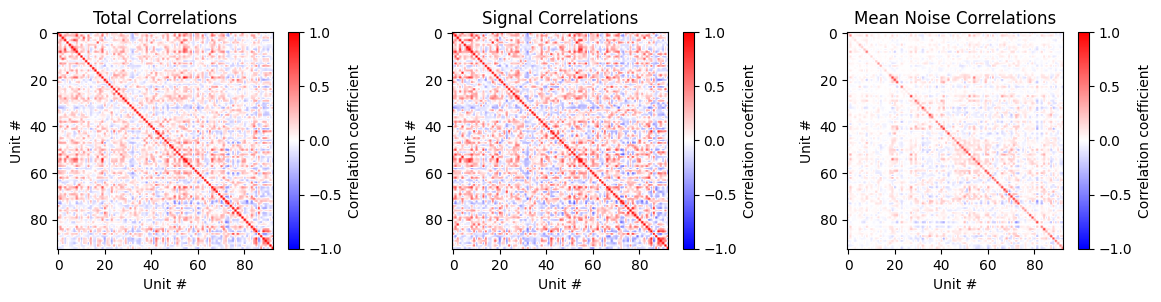

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
for i, c in enumerate((total_correlations, signal_correlations, mean_noise_correlations)):
    plt.colorbar(ax[i].imshow(c, cmap='bwr', clim=(-1,1)), label='Correlation coefficient')
    ax[i].set_title(f"{('Total', 'Signal', 'Mean Noise')[i]} Correlations")
    ax[i].set_xlabel('Unit #')
    ax[i].set_ylabel('Unit #')
fig.tight_layout()

<div class="alert alert-block alert-success">
    
<strong>Prompt 2.3.d:</strong> For each stimulus condition, calculate the correlation with <code>'mean_running_speed'</code> for each unit. Plot the array (size #conditions x #units) of running speed correlations.

In [46]:
speed_condition = [np.array(stimulus_presentations["mean_running_speed"])[np.where(labels == stim)]
                   for stim in stimuli]

speed_correlations = np.array([[np.ma.corrcoef(r.T[n], s)[0,1] 
  for n in range(num_units)] for r,s in zip(responses_condition, speed_condition)])

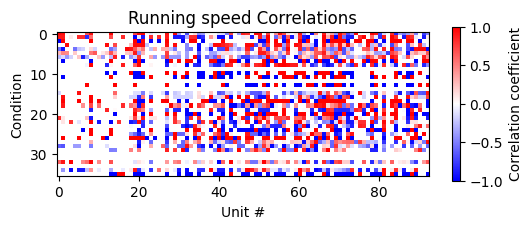

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(6,2))
plt.colorbar(ax.imshow(speed_correlations, cmap='bwr', clim=(-1,1)),
             label='Correlation coefficient')
ax.set_title("Running speed Correlations")
ax.set_xlabel('Unit #')
ax.set_ylabel('Condition');

<div class="alert alert-block alert-success">

<strong>Prompt 2.3.e:</strong> Consider the stimulus condition with the most stimulus presentations. For this condition, plot the <code>'speed_correlations'</code>, showing a threshold of 0.75. Get the indices of the <code>'highly_modulated_units'</code> whose correlation with running speed is greater than 0.75.

(5, array([19, 50, 51, 57, 66]))

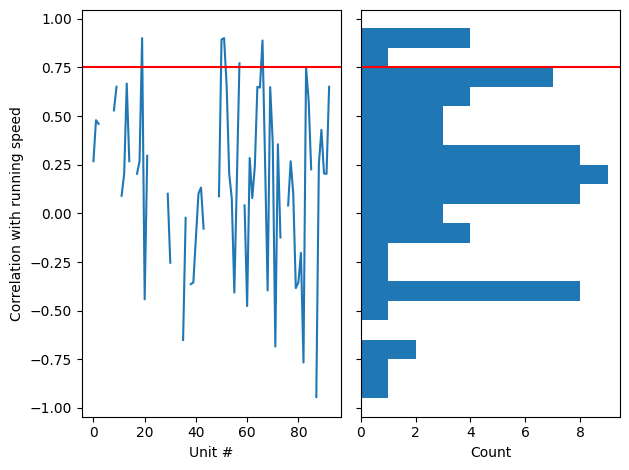

In [48]:
condition = np.argmax([len(s) for s in speed_condition])
# condition = np.argmax([np.sum(s) for s in speed_condition])
fig,ax = plt.subplots(1,2, sharey=True)
ax[0].plot(speed_correlations[condition])
ax[0].set_xlabel('Unit #')
ax[0].set_ylabel('Correlation with running speed')
ax[1].hist(speed_correlations[condition], np.arange(-.95,1,.1), orientation="horizontal")
ax[1].set_xlabel('Count')
for a in ax:
    a.axhline(.75, c='r')
fig.tight_layout()
highly_modulated = np.where(speed_correlations[condition] > .75)[0]
condition, highly_modulated

<div class="alert alert-block alert-success">
    
<strong>Prompt 2.3.f:</strong> Create plots comparing the noise correlations of <code>'highly_modulated_units'</code> to all units.
    
<ol>
<li>Plot the responses (for the considered condition) of those <code>'highly_modulated_units'</code> together with the running speed (use a separate y-axis for the latter).</li>
<li>In another panel, plot the noise correlations (for the considered condition) of the <code>'highly_modulated_units'</code>.</li>
<li>In another panel, plot the histogram of the off-diagonal elements of the noise correlations (for the considered condition) of (1) all units and (2) <code>'highly_modulated_units'</code> (use density, not counts).</li>
</ol>

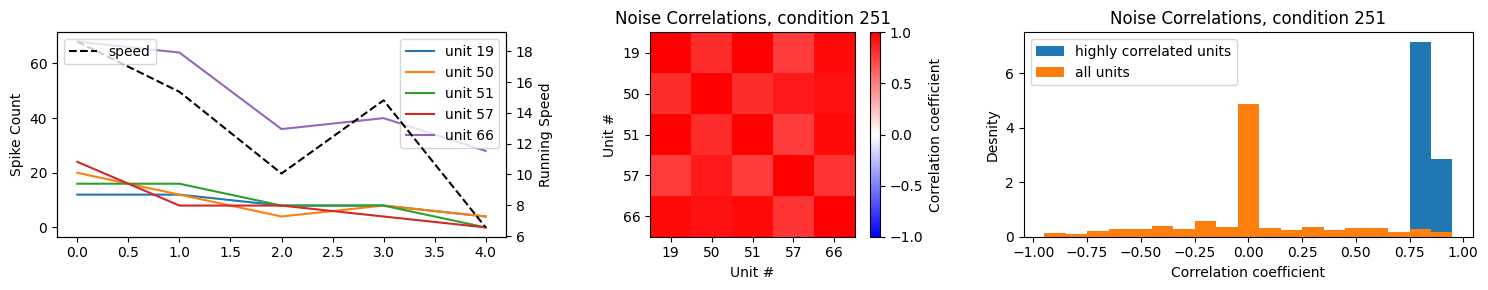

In [49]:
fig, ax = plt.subplots(1,3, figsize=(15,3), width_ratios=(3,2,3))
for i,n in enumerate(highly_modulated):
    ax[0].plot(responses_condition[condition][:,n], label=f"unit {n}")
ax[0].legend(loc=0)
ax[0].set_ylabel('Spike Count')
ax2 = ax[0].twinx()
ax2.plot(speed_condition[condition], 'k--', label='speed')
ax2.legend(loc=2)
ax2.set_xlabel('Stimulus Presentation')
ax2.set_ylabel('Running Speed')

plt.colorbar(ax[1].imshow(noise_correlations[condition][highly_modulated][:,highly_modulated],
                        cmap='bwr', clim=(-1,1)), label='Correlation coefficient')
ax[1].set_title(f"Noise Correlations, condition {stimuli[condition]}")
ax[1].set_xticks(range(len(highly_modulated)), highly_modulated)
ax[1].set_yticks(range(len(highly_modulated)), highly_modulated)
ax[1].set_xlabel('Unit #')
ax[1].set_ylabel('Unit #')

tri = np.triu_indices(len(highly_modulated), k=1)
ax[2].hist(noise_correlations[condition][highly_modulated][:,highly_modulated][tri],
         np.arange(-.95,1,.1), density=True, label="highly correlated units")
tri = np.triu_indices(len(noise_correlations[condition]), k=1)
ax[2].hist(noise_correlations[condition][tri], np.arange(-.95,1,.1), density=True, label="all units")
ax[2].legend()
ax[2].set_title(f"Noise Correlations, condition {stimuli[condition]}")
ax[2].set_xlabel('Correlation coefficient')
ax[2].set_ylabel('Desnity')
fig.tight_layout();

<div class="alert alert-block alert-success">

<strong>Prompt 2.3.g:</strong> Create synthetic data with removed noise correlations by trial-shuffling the neural data (for each condition).

In [50]:
shuffled_responses_condition = []
for r in responses_condition:
    shuffled_responses_condition.append(r.copy())
    for j in range(num_units):
        np.random.shuffle(shuffled_responses_condition[-1][:,j])
shuffled_responses = np.concatenate(shuffled_responses_condition)
shuffled_responses = shuffled_responses[np.argsort(np.argsort(labels))]

<div class="alert alert-block alert-success">

<strong>Prompt 2.3.h:</strong> Decode the stimuli using a linear SVM on the true and shuffled responses. Repeatedly split into 'train' and 'test' data using <code>StratifiedKFold</code> or <code>LeaveOneOut</code> and calculate the accuracies averaged over splits.
<p> Why not just use KFold as we did in the workshop?
</div>

<details>
    <summary>Click for a <strong>Hint:</strong></summary>
    Consider the number of presentations of each stimulus condition.
</details>

In [51]:
num_splits = 5
for random_state in (0,1):
    print(f"\nRandom state: {random_state}")
    for Fold in (KFold(n_splits=num_splits, shuffle=True, random_state=random_state),
                 StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=random_state),
                 LeaveOneOut()):
        print(Fold)
        accuracies = []
        shuffled_accuracies = []
        for train_indices, test_indices in Fold.split(responses, labels):
            for r,a in ((responses, accuracies), (shuffled_responses, shuffled_accuracies)):
                clf = svm.SVC()
                clf.fit(r[train_indices], labels[train_indices])
                test_targets = labels[test_indices]
                test_predictions = clf.predict(r[test_indices])
                accuracy = np.mean(test_targets == test_predictions)    
                a.append(accuracy)

        print(f'Mean accuracy:          {np.mean(accuracies)}')
        print(f'Mean accuracy shuffled: {np.mean(shuffled_accuracies)}')


Random state: 0
KFold(n_splits=5, random_state=0, shuffle=True)
Mean accuracy:          0.147953216374269
Mean accuracy shuffled: 0.1584795321637427
StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
Mean accuracy:          0.21403508771929824
Mean accuracy shuffled: 0.18128654970760233
LeaveOneOut()
Mean accuracy:          0.1702127659574468
Mean accuracy shuffled: 0.1595744680851064

Random state: 1
KFold(n_splits=5, random_state=1, shuffle=True)
Mean accuracy:          0.10701754385964912
Mean accuracy shuffled: 0.09649122807017543
StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
Mean accuracy:          0.20233918128654968
Mean accuracy shuffled: 0.20233918128654968
LeaveOneOut()
Mean accuracy:          0.1702127659574468
Mean accuracy shuffled: 0.1595744680851064


In [52]:
num_splits = 5
for random_state in (0,1):
    print(f"\nRandom state: {random_state}")
    for Fold in (RepeatedKFold(n_splits=num_splits, random_state=random_state),
                 RepeatedStratifiedKFold(n_splits=num_splits, random_state=random_state),
                 LeaveOneOut()):
        print(Fold)
        accuracies = []
        shuffled_accuracies = []
        for train_indices, test_indices in Fold.split(responses, labels):
            for r,a in ((responses, accuracies), (shuffled_responses, shuffled_accuracies)):
                clf = svm.SVC()
                clf.fit(r[train_indices], labels[train_indices])
                test_targets = labels[test_indices]
                test_predictions = clf.predict(r[test_indices])
                accuracy = np.mean(test_targets == test_predictions)    
                a.append(accuracy)

        print(f'Mean accuracy:          {np.mean(accuracies)}')
        print(f'Mean accuracy shuffled: {np.mean(shuffled_accuracies)}')


Random state: 0
RepeatedKFold(n_repeats=10, n_splits=5, random_state=0)
Mean accuracy:          0.12228070175438596
Mean accuracy shuffled: 0.11894736842105262
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0)
Mean accuracy:          0.19239766081871348
Mean accuracy shuffled: 0.20064327485380118
LeaveOneOut()
Mean accuracy:          0.1702127659574468
Mean accuracy shuffled: 0.1595744680851064

Random state: 1
RepeatedKFold(n_repeats=10, n_splits=5, random_state=1)
Mean accuracy:          0.11807017543859648
Mean accuracy shuffled: 0.11912280701754384
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=1)
Mean accuracy:          0.19228070175438597
Mean accuracy shuffled: 0.20479532163742692
LeaveOneOut()
Mean accuracy:          0.1702127659574468
Mean accuracy shuffled: 0.1595744680851064


In [53]:
stimulus_presentations.image_name.value_counts()

251    5
246    4
263    4
283    4
252    4
278    4
250    4
280    3
285    3
271    3
247    3
276    3
264    3
249    3
266    3
272    3
273    3
267    3
254    3
279    3
277    2
248    2
270    2
275    2
265    2
253    2
286    2
259    2
257    2
256    2
284    1
258    1
255    1
282    1
281    1
262    1
Name: image_name, dtype: int64

<div class="alert alert-block alert-success">

<strong>Prompt 2.3.i:</strong> We considered <code>'drifting_gratings'</code>. Change to a static stimulus set and run all cells of this exercise again.